# EXPLORATORY DATA ANALYSIS - HOME CREDIT DEFAULT RISK

## Introduction
Home Credit is an international consumer finance provider which operates in 9 countries. It provides point of sales loans, cash loans and revolving loans to underserved borrowers. The term undeserved borrower here refers to those who earn regular income from their job or businesses, but have little or no credit history and find it difficult to get credits from other traditional lending organizations. They believe that the credit history should not be a barrier for a borrower to fulfill their dreams.

Over 22 years of track record, they have accumulated a large amount of borrower behavioural data which they leverage to provide financial assistance to such customers. They have built predictive models that help them to efficiently analyze the risk associated with a given client and also estimate the safe credit amount to be lent to customers, even with no credit history.


## Dataset
### Data Overview
Home Credit Group has generously provided a vast dataset to motivate machine learning engineers and researchers to come up with techniques to build a predictive model for default risk prediction. Generally, the data in the field of Finances tend to be very much variant and collecting such data can be very tedious task, but in this case, Home Credit has done most of the heavy lifting to provide us as clean of a data as possible.

The dataset provided contains a vast number of details about the borrower. It is separated into several relational tables, which contain applicants’ static data such as their gender, age, number of family members, occupation, and other necessary fields, applicant’s previous credit history obtained from the credit bureau department, and the applicant’s past credit history within the Home Credit Group itself. The dataset is an imbalanced dataset, where the negative class dominates the positive class, as there are only a few number of defaulters among all the applicants.

The Dataset can be downloaded from the Kaggle link: Home Credit Default Risk Dataset


### Data Specifications
There are 10 .csv files in total. They are:

- HomeCredit_columns_description.csv - 36.51 KB
- POS_CASH_balance.csv -               374.51 MB
- application_test.csv -               25.34 MB
- application_train.csv -              158.44 MB
- bureau.csv -                         162.14 MB
- bureau_balance.csv -                 358.19 MB
- credit_card_balance.csv -            404.91 MB
- installments_payments.csv -          689.62 MB
- previous_application.csv -           386.21 MB
- sample_submission.csv -              523.63 KB



## Preliminary Steps
Loading the libraries and modules

Let's start by loading the essential libraries and modules. We will also set the max columns and max rows display limit to None for Pandas DataFrames to be able to see the whole DataFrame.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
    
import warnings
warnings.filterwarnings('ignore')

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

#pandas DataFrame column and row display limits
pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

## Defining Utility Functions
The whole notebook has been created in modular form. Each of the recurring code block has been put into function to eliminate redundant code.

In [2]:
application_train = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\application_train.csv")
application_test = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\application_test.csv")
bureau = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\bureau.csv")
bureau_balance = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\bureau_balance.csv")
POS_CASH_balance = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\POS_CASH_balance.csv")
cc_balance = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\credit_card_balance.csv")
installments_payments = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\installments_payments.csv")
previous_application = pd.read_csv(r"C:\Users\Duong Nguyen\Desktop\final_project\home-credit-default-risk\previous_application.csv")

In [3]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [4]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

In [5]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

In [6]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    '''
    Function to Phi_k matrix for categorical features
    
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    
    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100)


In [7]:
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):
    
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
        
    '''
    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()


In [25]:

def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):
    
    '''
    Function to plot categorical variables Pie Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''
    
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution ', f'Percentage of Defaulters']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)
    
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()

In [9]:
def print_unique_categories(data, column_name, show_counts = False):
    
    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables
    
        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not

    '''
    
    print('-'*100)
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    print('-'*100)
    
    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        print('-'*100)

In [10]:
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):
    
    '''
    Function to plot CDF of a continuour variable
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose CDF is to be plotted
        log_scale: bool, default = True
            Whether to use log-scale (for widely varying values) or not
        figsize: tuple, default = (12,8)
            The size of figure to be plotted    
    '''
    
        
    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()

In [11]:

def print_percentiles(data, column_name, percentiles = None):
    
    '''
    Function to print percentile values for given column
    
    Inputs:
        data: DataFrame
            The DataFrame from which to print percentiles
        column_name: str
            Column's name whose percentiles are to be printed
        percentiles: list, default = None
            The list of percentiles to print, if not given, default are printed
    '''
    
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

In [12]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

## EDA
For the data analysis, we will follow following steps:

1. For each table, we will first check basic stats like the number of records in tables, number of features, number of NaN values, etc.
2. Next, we will explore some of the features with respect to the target variable for each table. We will be employing the following plots
- For Categorical Features, we will mostly be using Bar Plots and Pie Charts.
- For continuous/numeric features, we will be using Box-Plots, PDFs, CDF, and Violin-Plots.
3. We will be drawing observations from each plot and note important insights generated from the plots.

**Note 1**:
- For Categorical Variables, we will be plotting the Bar Plots and Pie Plots. The use of Bar and Pie Plot will be based on the Number of unique categories present in a feature. If a feature has too many categories, displaying them on Pie Plots can be cumbersome, and Bar Plot does a better job of showing each category. Also Bar Plot will be preferred when the proportions of all the categories are more or less the same to identify small differences
- We will be following the below mentioned strategy for plotting for Categorical Features in the whole notebook:
    - First, we will be plotting the distribution of each category in the whole data, in the first subplot.
    - Next, in the second subplot, we will be plotting the Percentage of Defaulters from each category, i.e. with Target = 1.
    - For example, say if a feature contains Gender, viz. Male and Female, so for first subplot we will plot the number of occurrences of each of Male and Female in our dataset.
        In the second subplot, we will be plotting that out of the counts of Male present in the dataset, how many or what percentage of Males were found to Default. Similarly we will do this for Female.
This is being done because there will be few categories which will be dominant over others, and their Default characteristics would not be identifiable if we look at just the counts.

**Note 2**:
For the analysing the continuous variables, we will use four kinds of plots as and when needed, which are Distplot, CDF, Box-plots and Violin Plots.

- DistPlots:
    The distplot will be used when we want to see the PDFs of the continuous variable. This PDF will help us to analyze where most of our data is lying.
- CDF:
    CDFs can be used as an extention to PDFs to see what percentage of points lie below a certain threshold value. This would give us a good estimate of the distribution of majority of data.
- Box-Plots:
    Box-plots are helpful when we want to analyze the whole range of values that our continuous variable has. It shows the 25th, 50th and 75th percentile in a single plot. Moreover, it also gives some ideas related to presence of outliers in a given set of values.
- Violin-Plots:
    Violin-plots tend to combine the features of both Distplots and Box-Plots. Vertically they mimic the box-plot and show the quantiles, range of values, and horizontally they show the PDF of the continuous variable.

### application_train.csv and application_test.csv

Description:

- The application_train.csv table consists of static data relating to the Borrowers with labels. Each row represents one loan application.
- The application_test.csv contains the testing dataset, and is similar to application_train.csv, except that the TARGET column has been omitted, which has to be predicted with the help of Statistical and Machine Learning Predictive Models.

Basic Stats

In [13]:
print('-'*100)
print(f'The shape of application_train.csv is: {application_train.shape}')
print('-'*100)
# print(f'Number of duplicate values in application_train: {application_train.shape[0] - application_train.duplicated().shape[0]}')
# print('-'*100)
display(application_train.head())

----------------------------------------------------------------------------------------------------
The shape of application_train.csv is: (307511, 122)
----------------------------------------------------------------------------------------------------


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [14]:
print('-'*100)
print(f'The shape of application_test.csv is: {application_test.shape}')
print('-'*100)
# print(f'Number of duplicate values in application_test: {application_test.shape[0] - application_test.duplicated().shape[0]}')
# print('-'*100)
display(application_test.head())

----------------------------------------------------------------------------------------------------
The shape of application_test.csv is: (48744, 121)
----------------------------------------------------------------------------------------------------


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working               Higher education   
1   Unaccompanied          Working  Secondary / secondary special   
2             NaN          Working               Higher education   
3   Unaccompanied          Working  Secondary / secondary special   
4   Unaccompanied          Working  Secondary / secondary special   

  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0            Married  House / apartment                    0.018850   
1            Married  House / apartment                    0.035792   
2            Married  House / apartment                    0.019101   
3            Married  House / apartment                    0.026392   
4            Married  House / apartment                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0      -19241          -2329            -5170.0             -812          NaN   
1      -18064          -4469            -9118.0            -1623          NaN   
2      -20038          -4458            -2175.0            -3503          5.0   
3      -13976          -1866            -2000.0            -4208          NaN   
4      -13040          -2191            -4000.0            -4262         16.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           0   
1           1               1                0                 1           0   
2           1               1                0                 1           0   
3           1               1                0                 1           1   
4           1               1                1                 1           0   

   FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           1                 NaN              2.0                     2   
1           0  Low-skill Laborers              2.0                     2   
2           0             Drivers              2.0                     2   
3           0         Sales staff              4.0                     2   
4           0                 NaN              3.0                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                    TUESDAY   
1                            2                     FRIDAY   
2                            2                     MONDAY   
3                            2                  WEDNESDAY   
4                            2                     FRIDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       18                           0   
1                        9                           0   
2                       14                           0   
3                       11                           0   
4                        5                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                   

Observations and Conclusions:

1. application_train.csv:
- The application_train.csv file has approx 307k records, and 122 features. These features contain the personal statistics belonging to a particular customer such as his Age, Income, Type of Loan, Apartment Stats, etc.
- There are 307k unique SK_ID_CURR which represent unique loan applications.
- The TARGET field represents the Loan-Default Status, 0 stands for Non-Defaulter, and 1 for Defaulter.

2. application_test.csv:
- The application_test.csv file has approx 48.7k records, and 121 features. These features are exactly those which are in application_train.csv, except that these are the training sets.
- There are 48.7k unique SK_ID_CURR which represent unique loan applications.
- The TARGET column has been omitted and needs to be predicted by the help of Predictive Statistical and Machine Learning Models.

NaN Columns and Percentages

Number of columns having NaN values: 67 columns


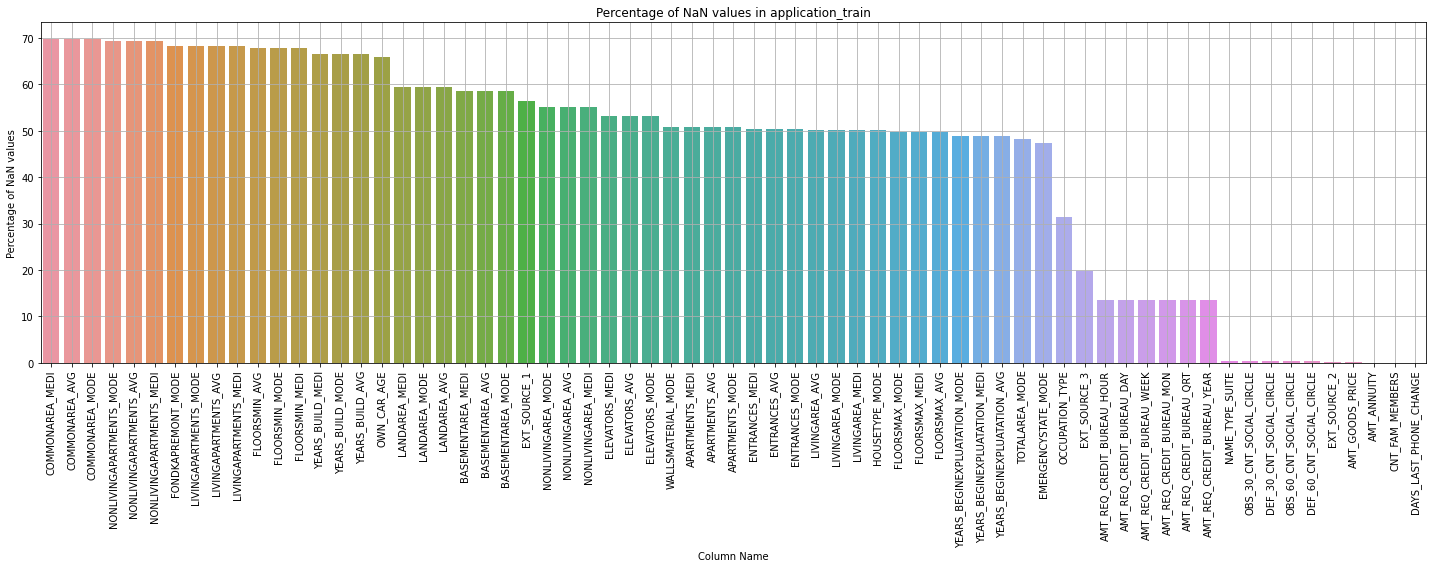

In [15]:
plot_nan_percent(nan_df_create(application_train), 'application_train', grid = True)

Number of columns having NaN values: 64 columns


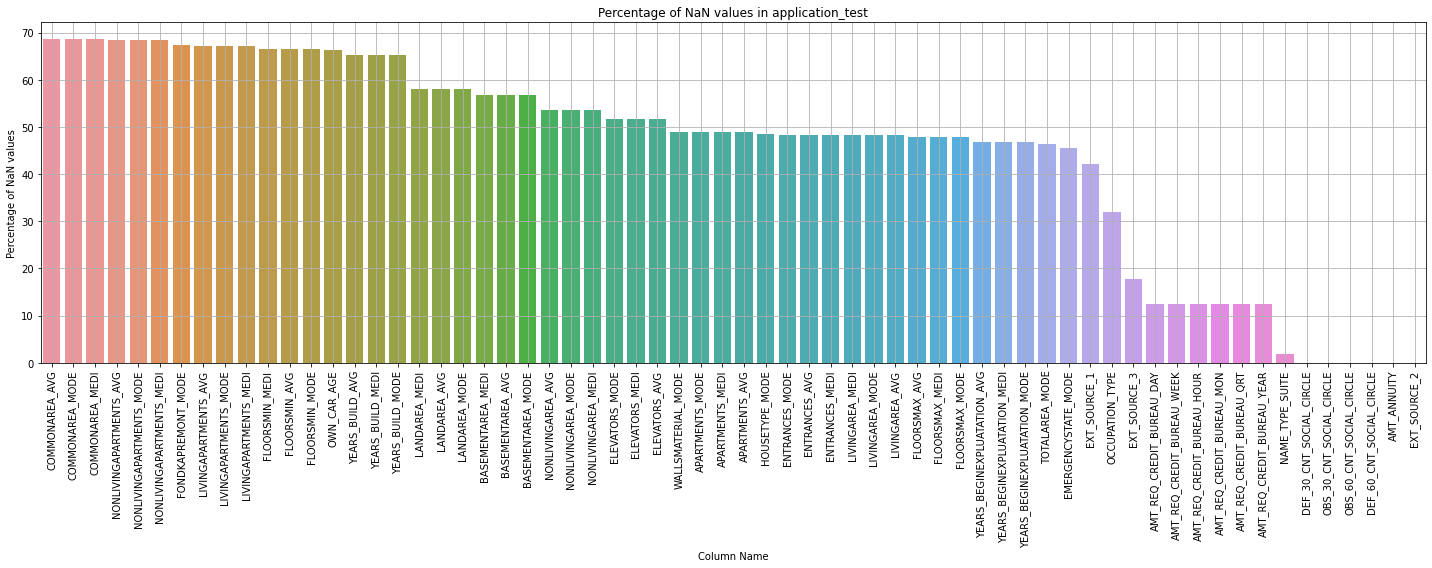

In [16]:
plot_nan_percent(nan_df_create(application_test), 'application_test', grid = True)

Observations and Conclusions:

application_train.csv:
- It can be seen from the above plot that there are 67 columns out of 122 features which contain NaN values. If there were just one or two columns which had NaN values, we could have gotten away with just eliminating those columns, but for such large number of columns, we cannot remove them as is, as loss of information could be very high.
- We see that some columns like relating to "COMMONAREA", "NONLIVINGAPARTMENT", etc. have close to 70% missing values. We would have to come up with techniques to handle these many missing values and see what would work best for our data.
- Another thing to note here is that most of the columns which have more than 50% missing values are related to the Apartments Statistics of the borrower. It is very likely that these values were not recorded during data entry, and could be optional.

application_test.csv:
- There are very similar number of columns with NaN values (64) as were with the application_train.
The percentages of NaN values are also quite similar to the ones present in training dataset. This means that the training and test sets are pretty much of similar distribution.

Distribution of Target Variable

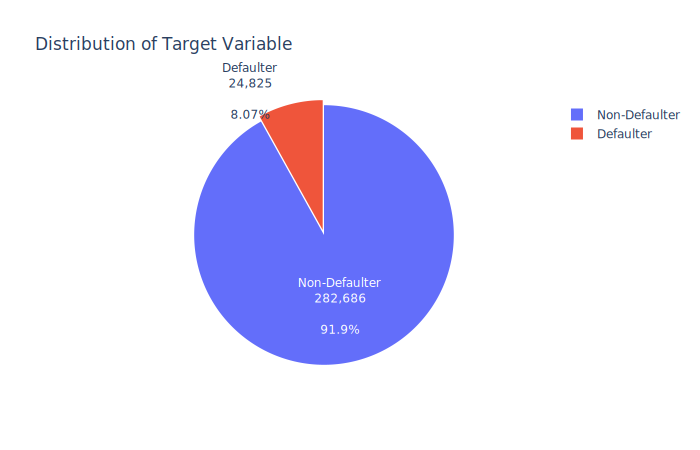

In [18]:
target_distribution = application_train.TARGET.value_counts()
labels = ['Non-Defaulter', 'Defaulter']

fig = go.Figure(data = [
        go.Pie(values = target_distribution, labels = labels, textinfo = 'label+percent+value' , pull = [0,0.04])], 
         layout = go.Layout(title = 'Distribution of Target Variable'))

fig.show(renderer = 'svg')

Observations and Conclusions:

- From the distribution of Target variable, one thing that we can quickly notice is the Data Imbalance. There are only 8.07% of the total loans that had actually been Defaulted. This means that Defaulters is the minority class.
- On the other hand, there are 91.9% loans which were not Defaulted. Thus, Non-Defaulters will be our majority class.
- The Defaulters have been assigned a Target variable of 1 and Non-Defaulters have been assigned Target Variable 0.
- For imbalanced dataset, during building the model, we cannot feed the data as is to some algorithms, which are imbalance sensitive.
- Similar is the case with the Performance Metrics. For such a dataset, Accuracy is usually not the right metric as the Accuracy would generally be biased to majority class. We can use other metrics such as ROC-AUC Score, Log-Loss, F1-Score, Confusion Matrix for better evaluation of model.
- One more important thing to note here is that there are very few people who actually default, and they tend to show some sort of different behaviour. Thus in such cases of Fraud, Default and Anamoly Detection, we need to focus on outliers too, and we cannot remove them, as they could be the differentiating factor between Defaulter and Non-Defaulter.

Phi-K matrix

We will plot a heatmap of the values of Phi-K Correlation Coefficient between each of the feature with the other.
The Phi-K coefficient is similar to Correlation Coefficient except that it can be used with a pair of categorical features to check if one feature shows some sort of association with the other categorical feature. It's max value can be 1 which would show a maximum association between two categorical variables.

----------------------------------------------------------------------------------------------------


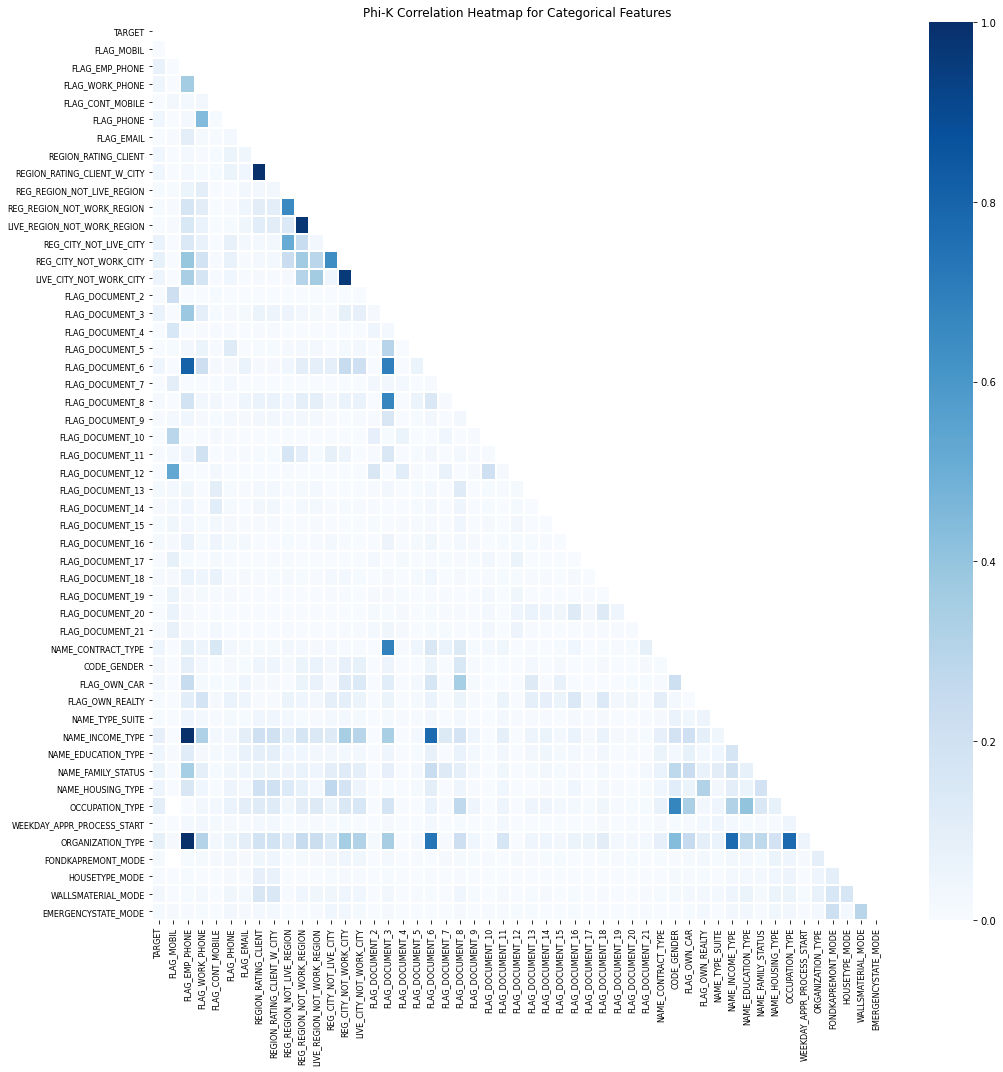

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
43          OCCUPATION_TYPE          0.102846
45        ORGANIZATION_TYPE          0.089164
39         NAME_INCOME_TYPE          0.084831
12   REG_CITY_NOT_WORK_CITY          0.079946
1            FLAG_EMP_PHONE          0.072087
11   REG_CITY_NOT_LIVE_CITY          0.069588
15          FLAG_DOCUMENT_3          0.069525
41       NAME_FAMILY_STATUS          0.056043
42        NAME_HOUSING_TYPE          0.051107
13  LIVE_CITY_NOT_WORK_CITY          0.050956

----------------------------------------------------------------------------------------------------


In [19]:
categorical_columns = ['TARGET','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                   'FLAG_PHONE', 'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                                   'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                                'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + application_train.dtypes[
                                    application_train.dtypes == 'object'].index.tolist()
plot_phik_matrix(application_train, categorical_columns, figsize = (15,15), fontsize = 8)

Observations and Conclusions:

1. From the above heatmap of Phi-K Correlation, we see that most of the categorical features are not correlated to each other, however some of them show strong correlation.
2. Some of the highly correlated Category pairs are:
- REGION_RATING_CLIENT_W_CITY and REGION_RATING_CLIENT - This is understandable as they would more or less tell a similar story.
- LIVE_REGION_NOT_WORK_REGION and REG_REGION_NOT_WORK_REGION
- NAME_INCOME_TYPE, ORGANIZATION_TYPE and FLAG_EMP_PHONE

We can also see some correlation between the Organization type and the income type of a client. Similarly we see a correlation between the Occupation Type and the Organization Type too.

We find that the category OCCUPATION_TYPE, ORGANIZATION_TYPE, NAME_INCOME_TYPE, REG_CITY_NOT_WORK_CITY are some of the highest correlated categories with the TARGET variable. These maybe important in the classification task, and would need further EDA

Correlation Matrix of Features

We will plot a heatmap of the correlation of each numeric feature with respect to other features. We have excluded the column SK_ID_CURR, as it does not have any relevance. This heatmap will help us identify the highly correlated numeric features and will also help us to identify features which are highly correlated with Target Variable.

----------------------------------------------------------------------------------------------------


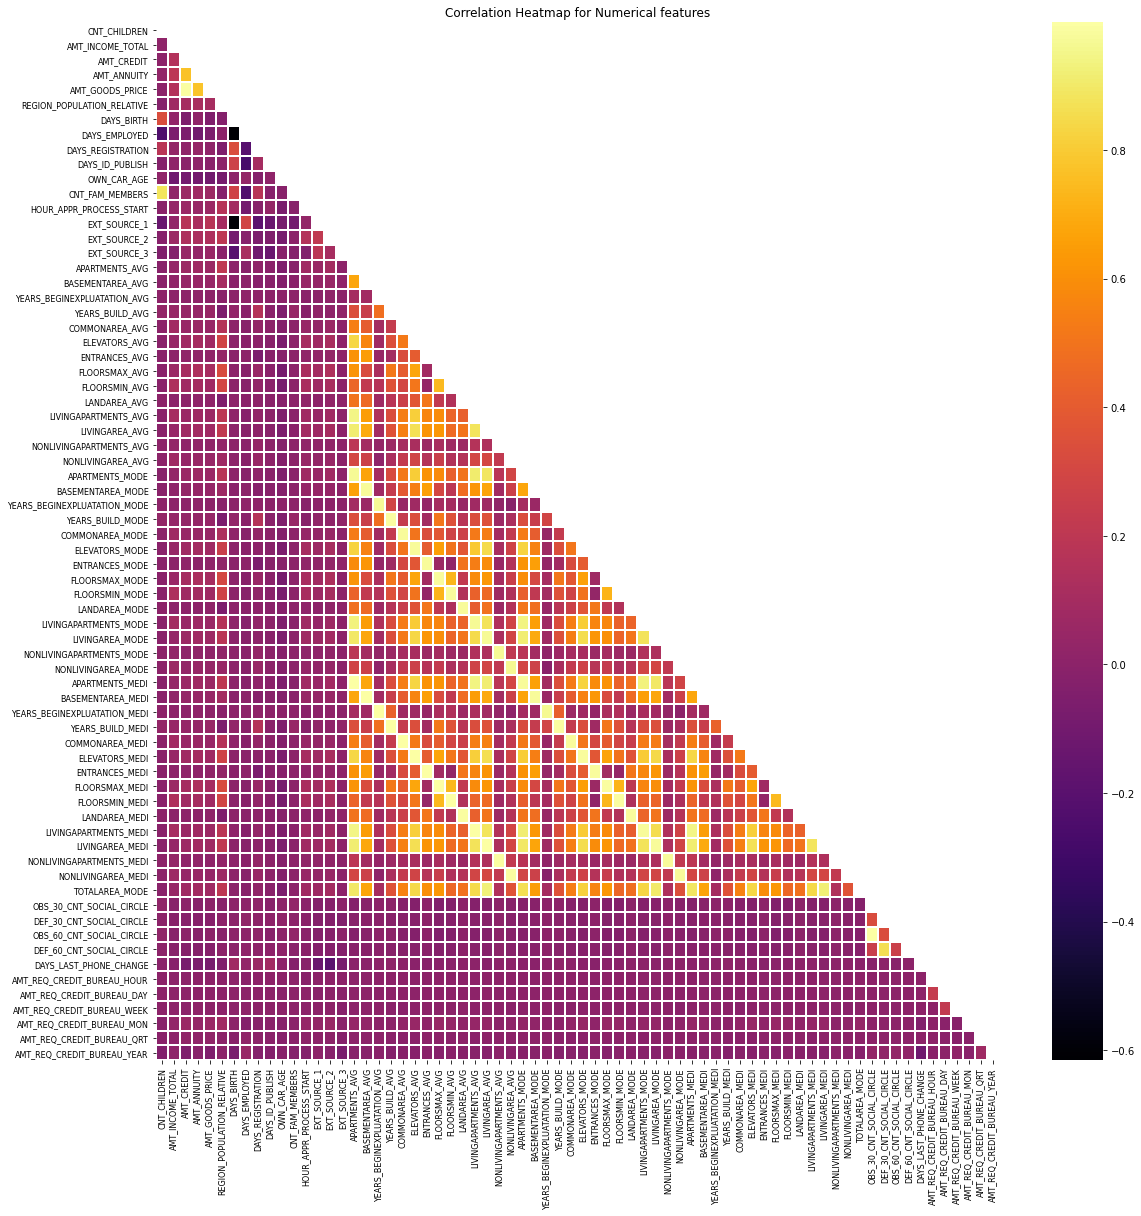

----------------------------------------------------------------------------------------------------


In [20]:
columns_to_drop = ['SK_ID_CURR'] + list(set(categorical_columns) - set(['TARGET']))
corr_mat = correlation_matrix(application_train, columns_to_drop, figsize = (17,17), fontsize = 8, cmap = 'inferno')
corr_mat.plot_correlation_matrix()

In [29]:
#Seeing the top columns with highest phik-correlation with the target variable in application_train table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns 

Column Name  Phik-Correlation
15            EXT_SOURCE_3          0.247680
13            EXT_SOURCE_1          0.217846
14            EXT_SOURCE_2          0.213965
6               DAYS_BIRTH          0.102378
63  DAYS_LAST_PHONE_CHANGE          0.073218
7            DAYS_EMPLOYED          0.072095
9          DAYS_ID_PUBLISH          0.067766
4          AMT_GOODS_PRICE          0.059094
23           FLOORSMAX_AVG          0.058826
51          FLOORSMAX_MEDI          0.058595

----------------------------------------------------------------------------------------------------


Observations and Conclusions:

- The heatmap does a good job of showing the value or level of correlation that each particular feature has with all other features.
It can be observed that most of the heatmap contains a purple-ish color, which indicates a very small value of correlation. This implies that most of the features are indeed not correlated to others.
- However, we can see contrasting shades at the middle of the heatmap. These shades depict a high value of correlation between the features. These are the features which are related to the stats of the apartments.
- If we look at the features of application_train, we can clearly see that the statistics of apartments are given in terms of Mean, Median and Mode, so it can be expected for the mean, median and mode to be correlated with each other. One more thing to note is that the features among particular category, for example Mean are also correlated with other mean features, such as Number of Elevators, Living Area, Non-Living Area, Basement Area, etc.
- We also see some high correlation between AMT_GOODS_PRICE and AMT_CREDIT, between DAYS_EMPLOYED and DAYS_BIRTH.
We would not want highly correlated features as they increase the time complexity of the model without adding much value to it. Hence, we would be removing the inter-correlated features.
- Among all the features, we see some high correlation for EXT_SOURCE features with respect to Target Variable. These might be important for our classification task.

Plotting Categorical Variables

This column contains information about the type of loan for the given applicant. As per the documentation provided by Home Credit, there are two types of loans, i.e. Revolving Loans and Cash Loans.

In [26]:
#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(application_train, 'NAME_CONTRACT_TYPE')

#plotting the Pie Plot for the column
plot_categorical_variables_pie(application_train, 'NAME_CONTRACT_TYPE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Cash loans' 'Revolving loans']
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


Observations and Conclusions:

From the above plot, we can draw following observations and conclusions:

- From the first subplot, i.e. the overall distribution:
    - It can be seen that most of the loans that the customers take are Cash Loans.
    - Only 9.52% of the people have taken Revolving Loans.
- From the second subplot, i.e. Percentage of Defaulters:
We see is that there are more percentage of people who have defaulted with Cash Loans (8.35%) as compared to those who defaulted with Revolving Loans (5.48%).

This column contains information about the Gender of the Client/Applicant.
Here M stands for Male and F for Female.

In [27]:
#let us first see the unique categories of 'CODE_GENDER'
print_unique_categories(application_train, 'CODE_GENDER', show_counts = True)

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, 'CODE_GENDER', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'CODE_GENDER' are:
['M' 'F' 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


Observations and Conclusions:

The Distribution of CODE_GENDER feature seems interesting. Here are some talking points:

- First point to observe is that there are 4 rows in the application_train table which have 'XNA' genders, which dont make much sense, and can be counted as NaN values. Since they are only 4 in Number and only belong to Non-Defaulter Category. So, we can eliminate those rows without much hesitation.
- From the subplot 1 we see that for the given dataset, there are more number of Female applicants (65.8%) than Male applicants (34.2%).
- However, contrary to the number of Female applicants, from the second plot we note that it has been seen that Male applicants tend to default more (10.14%) as compared to Female applicants (7%).

Thus, it can be said that Male have more tendency to default than Female as per the given dataset.

This column is a boolean column, which tells whether if the client provided his Work Phone Number or not.
Here 1 stands for Yes and 0 stands for No.

In [28]:
#let us first see the unique categories of 'FLAG_EMP_PHONE'
print_unique_categories(application_train, 'FLAG_EMP_PHONE')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, column_name = 'FLAG_EMP_PHONE', hole = 0.5)
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'FLAG_EMP_PHONE' are:
[1 0]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


Observations and Conclusions:

This feature contains two categories, i.e. if the client had provided his Work Phone Number during registration/application process or not.

- From the first subplot we see that most of the applicants do not provide their Work Phone Number (82%) and only 18% have provided their Work Phone Number.
- It can also be seen that the Default tendency for those who do provide Work Phone Number is more than those who do not provide Work Phone Number.

This is characteristic could be attributed to the fact that the Defaulters might be providing their Work Phone Numbers so that they don't get disturbed on their personal phone.

This feature is the rating provided by the Home Credit to each client's region based on the surveys that they might have done. This rating also takes into account the City in which the client lives.

Taking City into account is important because even if some regions have a good rating in a particular City, but that City doesn't have high rating, then applicant would be given a medium rating and not a high rating.

It contains values in the range from 1 to 3.

In [30]:
#let us first see the unique categories of 'REGION_RATING_CLIENT_W_CITY'
print_unique_categories(application_train, 'REGION_RATING_CLIENT_W_CITY')

#plotting the Pie Plot for the Column
plot_categorical_variables_pie(application_train, column_name = 'REGION_RATING_CLIENT_W_CITY')
print('-'*100)

----------------------------------------------------------------------------------------------------
The unique categories of 'REGION_RATING_CLIENT_W_CITY' are:
[2 1 3]
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


Observations and Conclusions:

From the above plots, we can draw following insights:

- From the first subplot, we see that most of the clients (74.6%) have a region rating of 2. This is the middle value which is for most of the applicants.
- Very few applicants have a region rating of 1 (only 11.1%) and some have a rating of 3 (14.3%).
- Among the Defaulters, it is seen that most of the defaulters have a region rating of 3 (11.4%) which is comparably higher to the other two ratings, i.e. clients with rating of 1 have a Defaulting percentage of just 4.84% and with rating 2 have a percentage of 7.92%.
- This shows that the rating 3 could be an important attribute for making a decision on Defaulting Characteristics.

This feature descibes/enlists the Highest Education that the client had achieved.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_EDUCATION_TYPE' are:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_EDUCATION_TYPE = 5


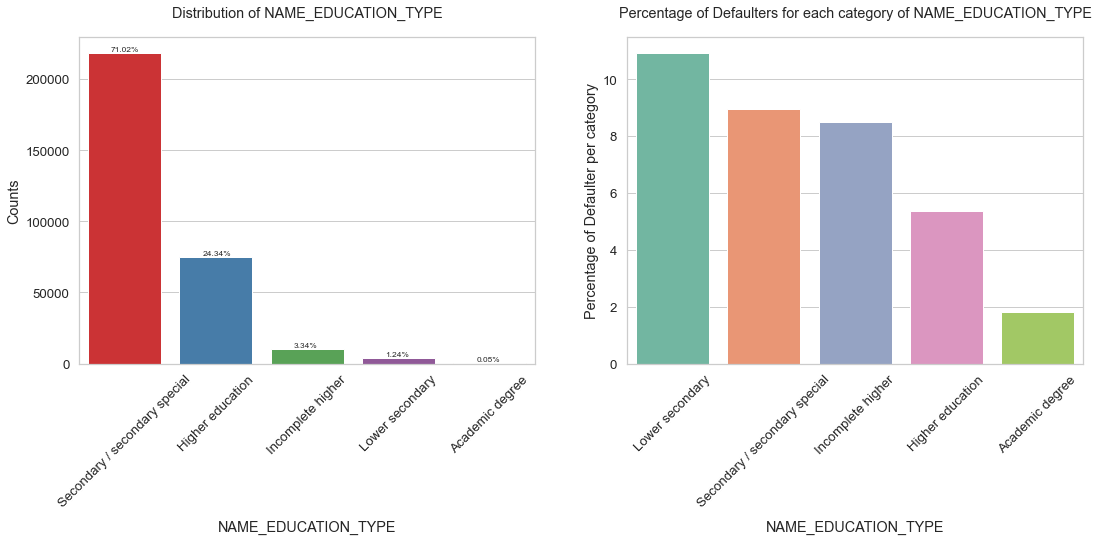

----------------------------------------------------------------------------------------------------


In [31]:
#let us first see the unique categories of 'NAME_EDUCATION_TYPE'
print_unique_categories(application_train, 'NAME_EDUCATION_TYPE', show_counts = True)

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(application_train, column_name = 'NAME_EDUCATION_TYPE', rotation = 45, horizontal_adjust = 0.25)
print('-'*100)

Observations and Conclusions:

- Looking at the above plots, we can conclude the following:

- About 71% of people have had their education only till Secondary/Secondary Special, along with 24.34% clients having done Higher Education. This suggests that most of the clients/borrowers don't have a high education level.
- From the second plot, we see that the people who have had their studies till only Lower Secondary have the highest Defaulting Characterists, with Secondary and Incomplete higher having similar defaulting tendencies.
- The group of people with Higher Education have comparably lower defaulting tendency, which is logical too. Also, people with Academic Degree show the least Defaulting Rate. However, the Academic Degree group are very few in numbers, so it might not be very useful.

This feature tells about the type of Occupation that the client has. This can be a very important feature which could describe the Defaulting Characteristics of a client. Let us see the plots for them.

----------------------------------------------------------------------------------------------------
The unique categories of 'OCCUPATION_TYPE' are:
['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of OCCUPATION_TYPE = 19


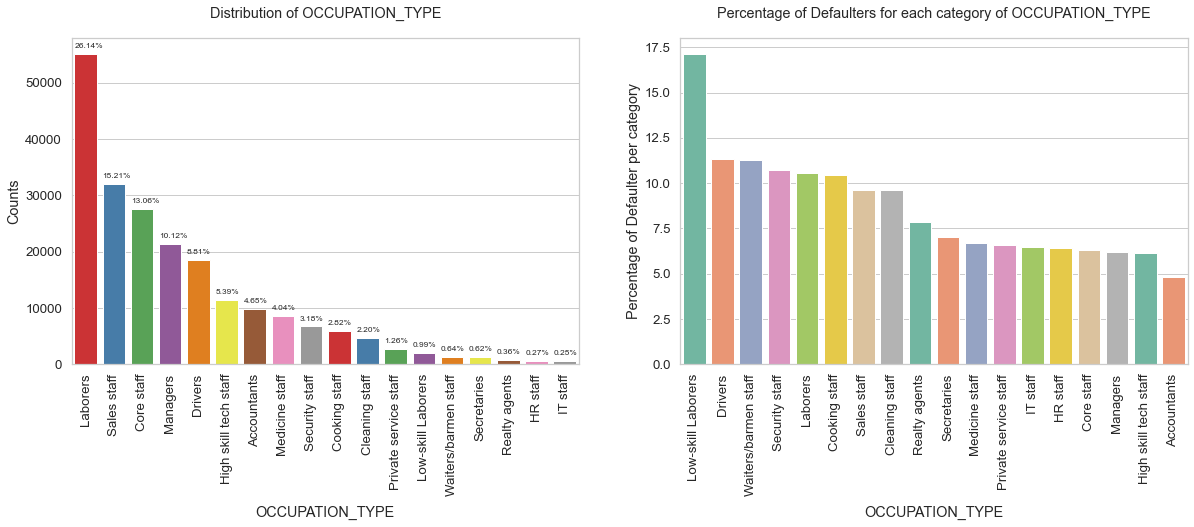

----------------------------------------------------------------------------------------------------


In [32]:
#let us first see the unique categories of 'OCCUPATION_TYPE'
print_unique_categories(application_train, 'OCCUPATION_TYPE')

#plotting the Bar Plot for the Column
plot_categorical_variables_bar(application_train, column_name = 'OCCUPATION_TYPE', figsize = (20,6), rotation = 90)
print('-'*100)

Observations and Conclusions:

From the plots of Occupation Type, we can draw following observations:

- Among the applicants, the most common type of Occupation is Laborers contributing to close to 26% applications. The next most frequent occupation is Sales Staff, followed by Core Staff and Managers.
- The Defaulting Rate for Low-Skill Laborers is the highest among all the occupation types (~17.5%). This is followed by Drivers, Waiters, Security Staff, Laborers, Cooking Staff, etc. All the jobs are low-level jobs. This shows that low-level Jobs people tend to have higher default rate.
- The lowest Defaulting Rate are among Accountants, Core Staff, Managers, High skill tech staff, HR staff, etc. which are from medium to high level jobs.
Thus it can be concluded that Low-level job workers tend to have a higher defaulting tendency compared to medium-high level jobs.

Similar to Occupation Type, Organization Type that the client belongs to could also be an important feature for predicting the Default Risk of that client. Let us visualize this feature in more detail.

Total Number of categories of ORGANIZATION_TYPE = 58


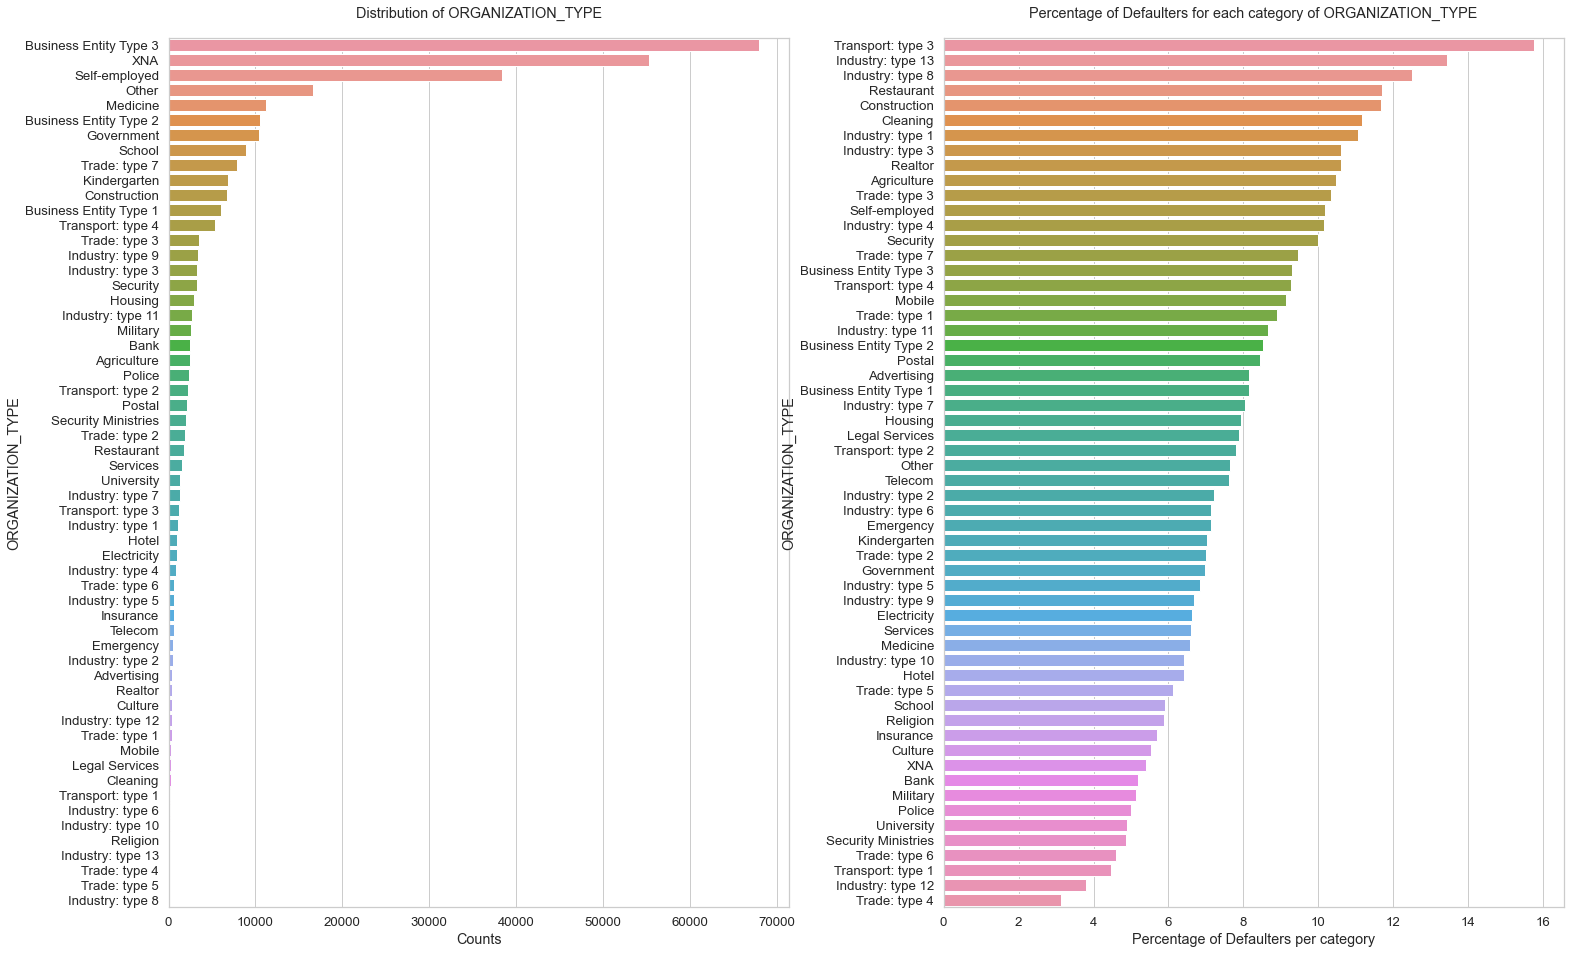

In [33]:
print(f"Total Number of categories of ORGANIZATION_TYPE = {len(application_train.ORGANIZATION_TYPE.unique())}")

plt.figure(figsize = (25,16))
sns.set(style = 'whitegrid', font_scale = 1.2)
plt.subplots_adjust(wspace=0.25)

plt.subplot(1,2,1)
count_organization = application_train.ORGANIZATION_TYPE.value_counts().sort_values(ascending = False)
sns.barplot(x = count_organization, y = count_organization.index)
plt.title('Distribution of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Counts')
plt.ylabel('ORGANIZATION_TYPE')

plt.subplot(1,2,2)
percentage_default_per_organization = application_train[application_train.TARGET == 1].ORGANIZATION_TYPE.value_counts() * 100 / count_organization
percentage_default_per_organization = percentage_default_per_organization.dropna().sort_values(ascending = False)
sns.barplot(x = percentage_default_per_organization, y = percentage_default_per_organization.index)
plt.title('Percentage of Defaulters for each category of ORGANIZATION_TYPE', pad = 20)
plt.xlabel('Percentage of Defaulters per category')
plt.ylabel('ORGANIZATION_TYPE')

plt.show()

Observations and Conclusions:

There are a lots of organization types which the client belongs to, 58 to be precise. The plots above give the following observations:

- From the first plot we see that most of the applicants work in Organizations of Type 'Business Entity Type3', 'XNA' or 'Self Employed'. The Organization Type 'XNA' could probably denote unclassified Organization TYpe.
- From the second plot, we notice that the applicants belonging to 'Transport: type 3' have the highest defaulting tendency as compared to the rest. They are followed by organizations of types: 'Industry: type 13', 'Industry: type 8', 'Restaurant', 'Construction', etc.
- The organizations which show lowest default rates are 'Trade: type 4', 'Industry: type 12', etc.
- These type numbers also would say something more about the Organization, however, we don't have any information related to that, so we will stick with the naming provided to us only.

REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY:

These columns include flags whether if the the client's permanent address matches with his Contact Address or Work Address or not at region level

LIVE_CITY_NOT_WORK_CITY This column indicates whether if the client's permanent address matches with his Contact Address at city level or not.

Here 1 indicates different addresses and 0 indicates same addresses.

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_LIVE_CITY = 2


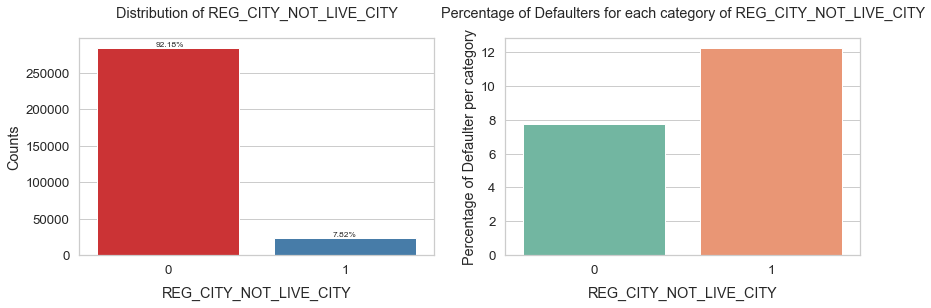

----------------------------------------------------------------------------------------------------
Total Number of unique categories of REG_CITY_NOT_WORK_CITY = 2


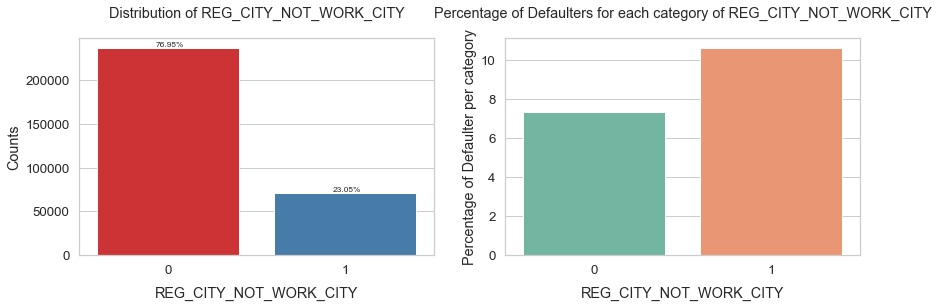

----------------------------------------------------------------------------------------------------
Total Number of unique categories of LIVE_CITY_NOT_WORK_CITY = 2


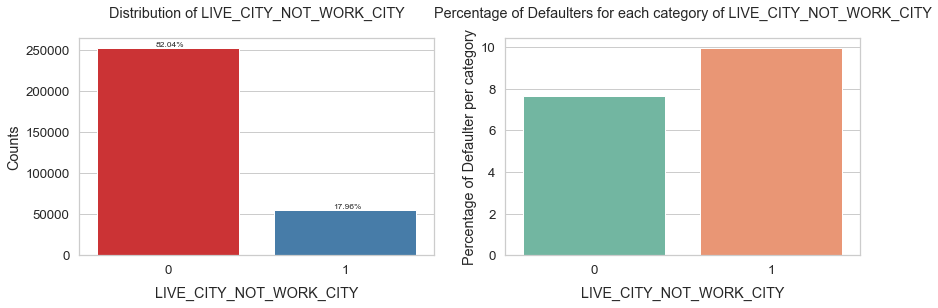

----------------------------------------------------------------------------------------------------


In [35]:
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'REG_CITY_NOT_LIVE_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'REG_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)
plot_categorical_variables_bar(application_train, column_name = 'LIVE_CITY_NOT_WORK_CITY', figsize = (14, 4), horizontal_adjust = 0.33)
print('-'*100)

Observations and Conclusions:

From the above 3 plots, following insights can be drawn:

Of all the applicants there are only a minority of applicants whose addresses do not match.
- Firstly, there are only 7.52% people who have different permanent address from their contact address at region level.
- Secondly, there are around 23.05% people who have different permanent address from their work address at region level. This higher number is explainable, because it is possible that they work in different region as compared to their permanent address.
- Lastly, there are around 17.96% people who have different permanent address from their contact address at city level.

If we look at the defaulting characteristics, we find that there is maximum defaulting tendency of those people who have their permanent and contact addresses different at region level, which is followed by different permanent and work address and lastly different permanent and contact address at city level.

For all the cases it is seen that the Defaulting tendency of those people who have different addresses is higher than those who have same address. This means that somewhere, this difference in address may suggest Defaulting Risk.


This columns contains the flag about a document that was to be submitted by the applicant. It's value is 0 if the client had provided the document and 1 if not.

Total Number of unique categories of FLAG_DOCUMENT_3 = 2


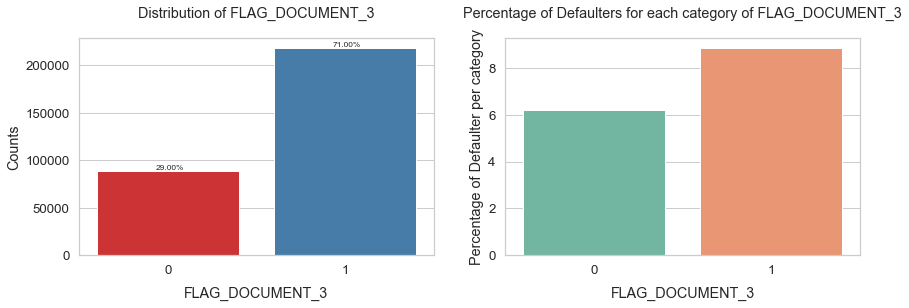

In [36]:
plot_categorical_variables_bar(application_train, column_name = 'FLAG_DOCUMENT_3', figsize = (14, 4), horizontal_adjust = 0.33)

Observations and Conclusions:

From the above plot, we see that:

- From the first subplot, we see that most of the clients hadn't provided this document (~71%) and only 29% did.
- From the second subplot, we see that those who had provided this document had a lower defaulting rate than those who didn't. This means that the applicants who had not provided the Document_3 tend to default more than those who had.


Plotting Continuous Variables

For the given dataset, the age is given in Days, which can be harder to interpret. Thus, we will create a latent variable to store the ages in Years, which would be easier to analyse and interpret.

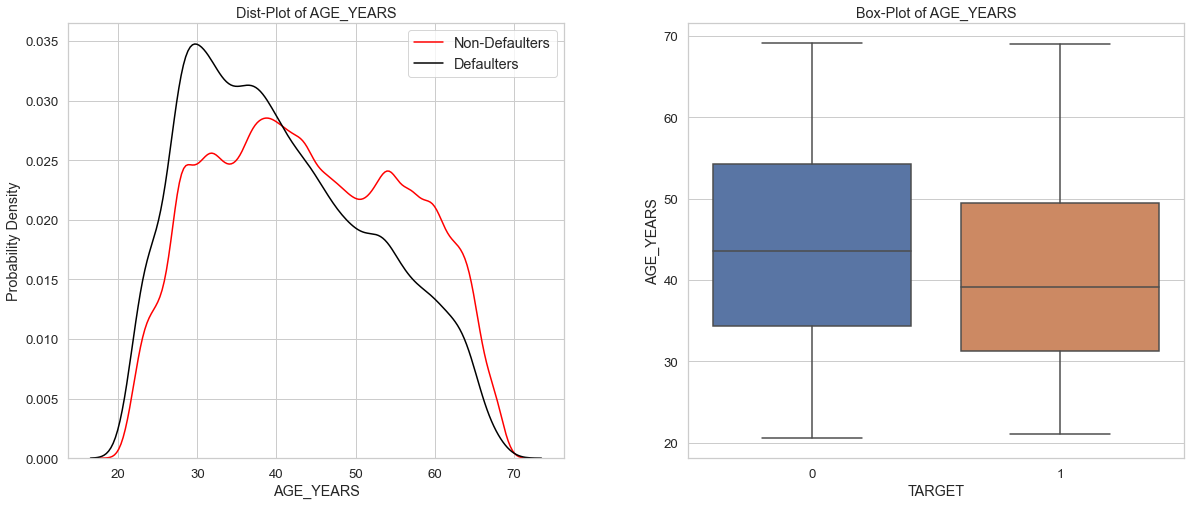

In [37]:
application_train['AGE_YEARS'] = application_train['DAYS_BIRTH'] * -1 / 365
plot_continuous_variables(application_train, 'AGE_YEARS', plots = ['distplot','box'])
_ = application_train.pop('AGE_YEARS')

Observations and Conclusions:

From the above two plots, we can draw some important insights.

- From the distplot, we can observe the peak of Age of people who Default to be close to 30 years. Also, at this point, the Non-Defaulters have a quite smaller PDF. One more thing to note is that the PDF of Age for Defaulters starts a bit left from the Non-Defaulters, and also is a bit throughtout the range. This means that the Defaulters are usually younger than Non-Defaulters.
- From CDF too we see that the probability
- From the box-plot too, we can better visualize the same thing. The Age of Defaulters is usually lesser than the Non-Defaulters. All the quantiles of ages of Defaulters is lesser than Non-Defaulters. The 75th percentile value of Non-Defaulters is around 54 years while for Defaulters it is near to 49 years.

These observations imply that the Defaulters are usually younger than Non-Defaulters.

DAYS_EMPLOYED

This feature tells about the number of days from the day of application the applicant had been employed. For easy interpretation, we will convert the days to years

----------------------------------------------------------------------------------------------------
The 0th percentile value of DAYS_EMPLOYED is -17912.0
The 25th percentile value of DAYS_EMPLOYED is -2760.0
The 50th percentile value of DAYS_EMPLOYED is -1213.0
The 75th percentile value of DAYS_EMPLOYED is -289.0
The 90th percentile value of DAYS_EMPLOYED is 365243.0
The 92th percentile value of DAYS_EMPLOYED is 365243.0
The 94th percentile value of DAYS_EMPLOYED is 365243.0
The 96th percentile value of DAYS_EMPLOYED is 365243.0
The 98th percentile value of DAYS_EMPLOYED is 365243.0
The 100th percentile value of DAYS_EMPLOYED is 365243.0
----------------------------------------------------------------------------------------------------


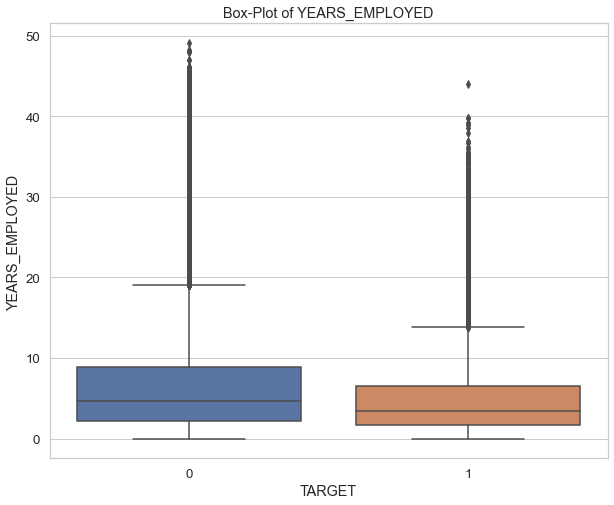

In [38]:
application_train['YEARS_EMPLOYED'] = application_train.DAYS_EMPLOYED * -1 / 365
print_percentiles(application_train, 'DAYS_EMPLOYED')
plot_continuous_variables(application_train, 'YEARS_EMPLOYED', plots = ['box'], scale_limits = [0,70], figsize = (10,8))
_ = application_train.pop('YEARS_EMPLOYED')

Observations and Conclusions:

We see that the DAYS_EMPLOYED column contains some erroneous datapoints with values 365243. These seem like some erroneous/non-sensicle values.

From the box plot we observe that the Defaulters seem to have less number of years being employed as compared to Non-Defaulters. All the 25th, 50th and 75th quantile for Defaulters are lesser than those of Non-Defaulters.

DAYS_ID_PUBLISH

This columns tells about how many days ago from the day of registration did the client change his Identity Document with which he applied for loan.

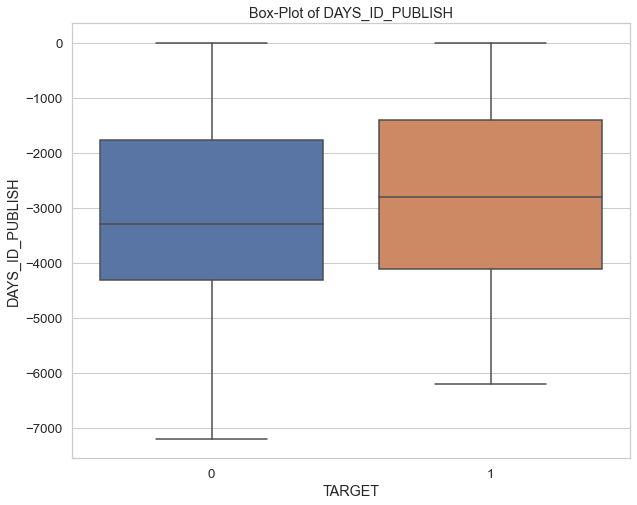

In [39]:
plot_continuous_variables(application_train, 'DAYS_ID_PUBLISH', plots = ['box'], figsize = (10,8))

Observations and Conclusions:

From the above box plot, we see a similar trend as seen with DAYS_REGISTRATION, in which the Defaulters usually had lesser number of days since they changed their identity. The Non-Defaulters show to have more number of days for all the quantiles since they changed their identity document.

CREDIT_TERM

This columns tells about how many days applied for loan.

In [ ]:
plot_continuous_variables(application_train, 'CREDIT_TERM', plots = ['box'], figsize = (10,8))

Observations and Conclusions:




There are three EXT_SOURCES columns, which contain values between 0 and 1. They are normalized scores from different sources

----------------------------------------------------------------------------------------------------


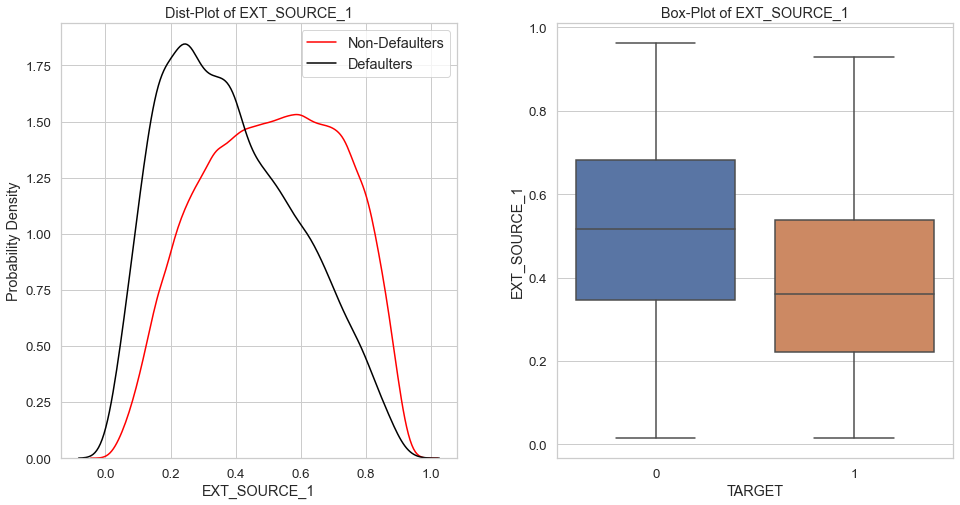

----------------------------------------------------------------------------------------------------


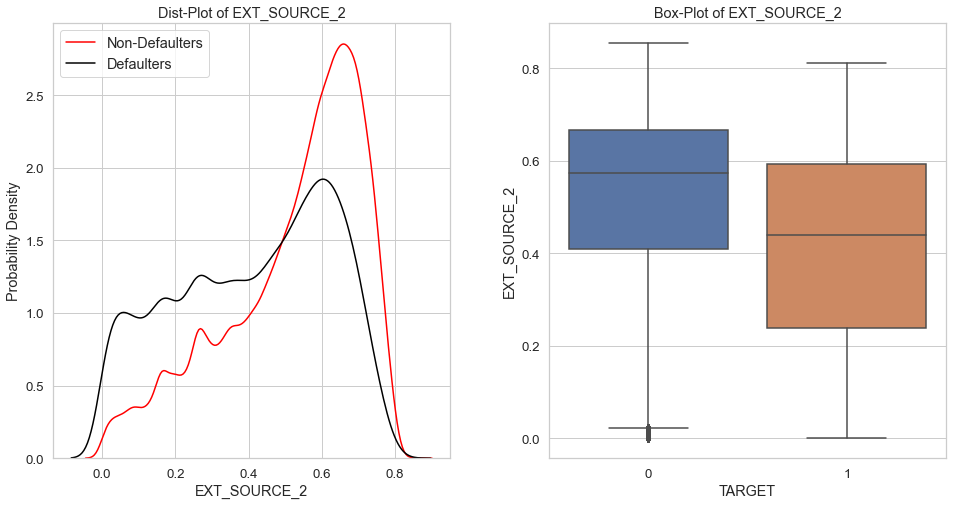

----------------------------------------------------------------------------------------------------


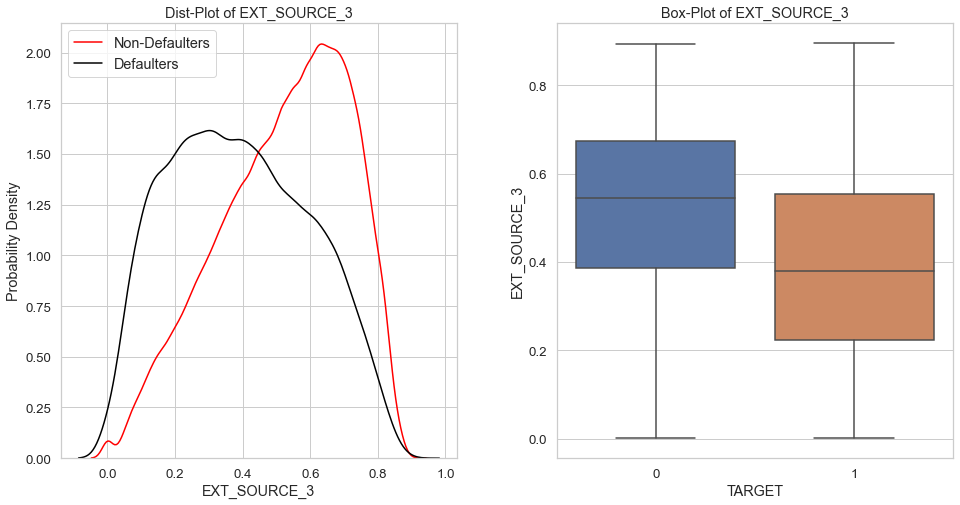

----------------------------------------------------------------------------------------------------


In [42]:
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_1', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_2', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_3', plots = ['distplot', 'box'], figsize = (16,8))
print('-'*100)

Observations and Conclusions:

From the above three plots, we can draw following conclusions:

- If we look at the box-plots, we can clearly see a similar trend for all three EXT_SOURCE columns, which is that the Defaulters tend to have considerably lower values.
- This trend can also be seen with the PDFs. The Non-Defaulters show a higher peak at high EXT_SOURCE values, and the Probability Densities are very low for low values. This implies that Non-Defaulters generally have high values of these scores.
- It is interesting to note that the median value for defaulters is almost equal to or lower than 25th percentile values of Non-Defaulters.
- EXT_SOURCE_1 and EXT_SOURCE_3 columns tend to show better discrimination/separability as compared to EXT_SOURCE_2.
These 3 features look to be best separating the Defaulters and Non-Defaulters linearly among all the features so far.

## previous_application.csv

In [43]:
print("-"*100)
print("Merging TARGET with previous_application Table")
prev_merged = application_train.iloc[:,:2].merge(previous_application, on = 'SK_ID_CURR', how = 'left')
print("-"*100)

----------------------------------------------------------------------------------------------------
Merging TARGET with previous_application Table
----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------


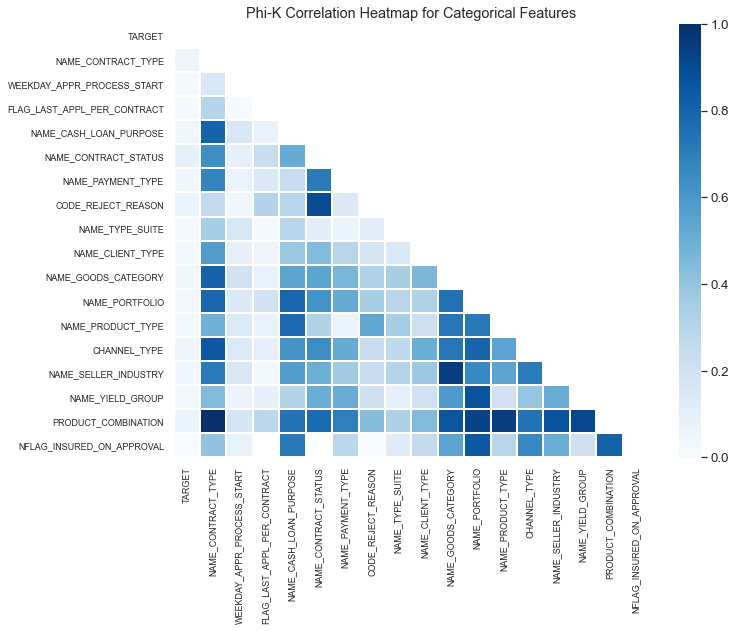

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


Column Name  Phik-Correlation
4     NAME_CONTRACT_STATUS          0.088266
15     PRODUCT_COMBINATION          0.063839
6       CODE_REJECT_REASON          0.062771
0       NAME_CONTRACT_TYPE          0.050859
12            CHANNEL_TYPE          0.050302
9      NAME_GOODS_CATEGORY          0.042951
3   NAME_CASH_LOAN_PURPOSE          0.040305
5        NAME_PAYMENT_TYPE          0.039752
13    NAME_SELLER_INDUSTRY          0.038077
14        NAME_YIELD_GROUP          0.034626

----------------------------------------------------------------------------------------------------


In [44]:
cols_for_phik = ['TARGET'] + prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() + ['NFLAG_INSURED_ON_APPROVAL']
plot_phik_matrix(prev_merged, cols_for_phik, cmap = 'Blues', figsize = (11,9), fontsize = 9)

Observations and Conclusions:

From the above heatmap of values of Phi-K Coefficient for Categorical Features, we observe that:

- The feature PRODUCT_COMBINATION shows association with lots of other features such as NAME_CONTRACT_TYPE, NAME_PRODUCT_TYPE, NAME_PORTFOLIO, etc.
- The feature NAME_GOODS_CATEGORY is also highly associated with NAME_SELLER_INDUSTRY
- If we look at the association with TARGET variable, we see that the features NAME_CONTRACT_STATUS, PRODUCT_COMBINATION, CODE_REJECT_REASON are some of the highest associated features, and would need further investigation

----------------------------------------------------------------------------------------------------


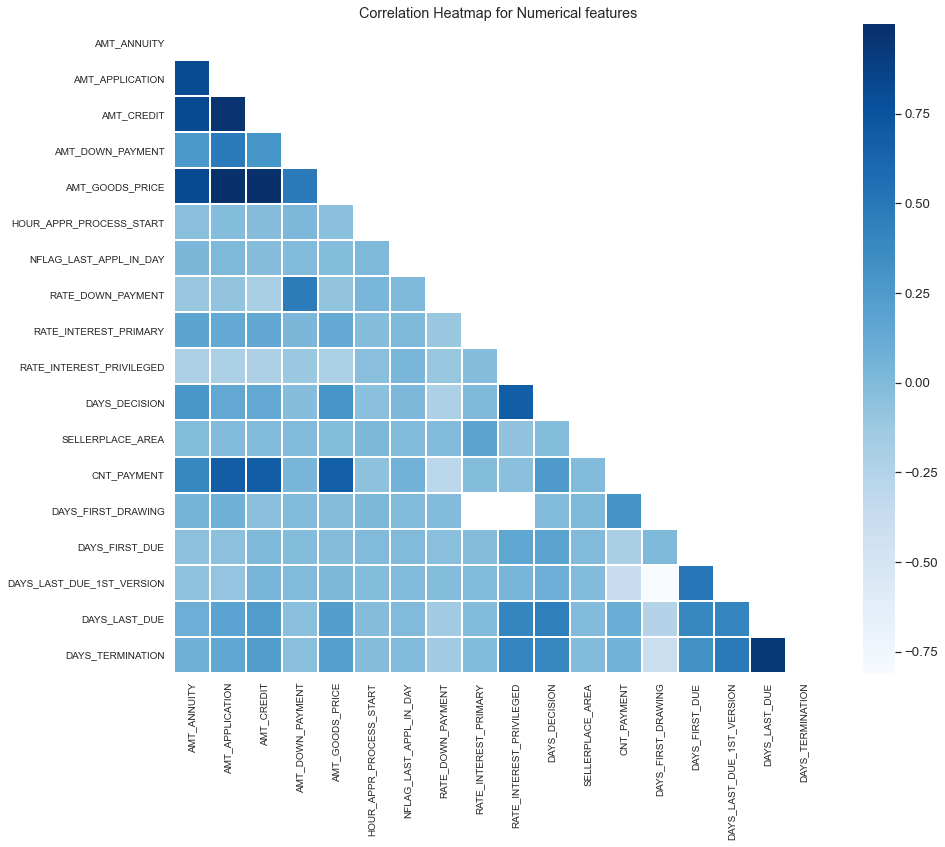

----------------------------------------------------------------------------------------------------


In [45]:
corr_mat = correlation_matrix(prev_merged, ['SK_ID_CURR','SK_ID_PREV','NFLAG_INSURED_ON_APPROVAL'], cmap = 'Blues', figsize = (14,12))
corr_mat.plot_correlation_matrix()

In [46]:
#Seeing the top columns with highest phik-correlation with the target variable in previous_applications table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)

interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_APPLICATION']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'NFLAG_LAST_APPL_IN_DAY']
interval columns not set, guessing: ['TARGET', 'RATE_DOWN_PAYMENT']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIMARY']
interval columns not set, guessing: ['TARGET', 'RATE_INTEREST_PRIVILEGED']
interval columns not set, guessing: ['TARGET', 'DAYS_DECISION']
interval columns not set, guessing: ['TARGET', 'SELLERPLACE_AREA']
interval columns not set, guessing: ['TARGET', 'CNT_PAYMENT']
interval columns not set, guessing: ['TARGET', 'DAYS_FIRST_DRAWING']
interval columns not set, guessing: ['TARGET', 'DAYS_F

Column Name  Phik-Correlation
12                CNT_PAYMENT          0.056639
10              DAYS_DECISION          0.053694
13         DAYS_FIRST_DRAWING          0.048993
7           RATE_DOWN_PAYMENT          0.039592
5     HOUR_APPR_PROCESS_START          0.038121
9    RATE_INTEREST_PRIVILEGED          0.028204
15  DAYS_LAST_DUE_1ST_VERSION          0.027878
16              DAYS_LAST_DUE          0.027320
17           DAYS_TERMINATION          0.026479
0                 AMT_ANNUITY          0.013808

----------------------------------------------------------------------------------------------------


### Plotting Categorical Variables

This column descibes the type of the Contract of the previous loan with the Home Credit Group.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_TYPE' are:
['Consumer loans' 'Cash loans' 'Revolving loans' nan 'XNA']
----------------------------------------------------------------------------------------------------
Counts of each category are:
Cash loans         626764
Consumer loans     625256
Revolving loans    161368
XNA                   313
Name: NAME_CONTRACT_TYPE, dtype: int64
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_TYPE = 5


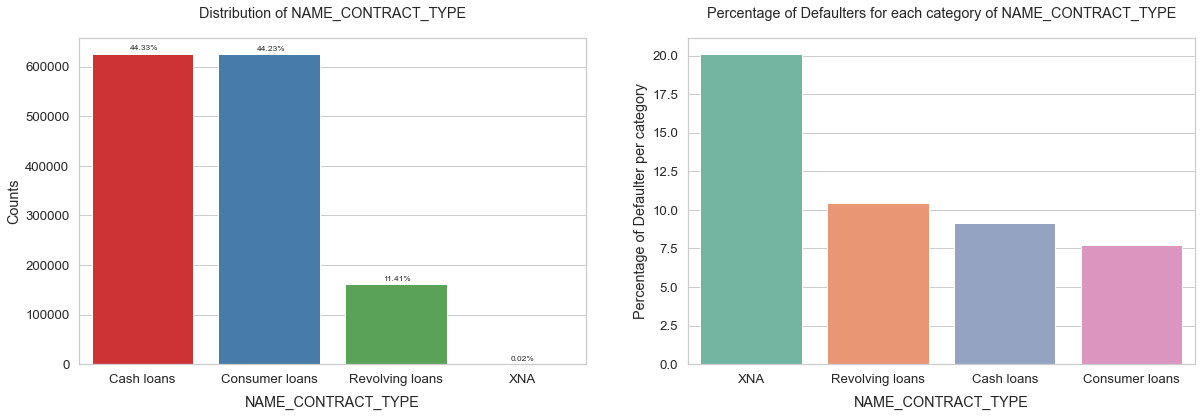

----------------------------------------------------------------------------------------------------


In [47]:
#let us first see the unique categories of 'NAME_CONTRACT_TYPE'
print_unique_categories(prev_merged, 'NAME_CONTRACT_TYPE', show_counts = True)

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_TYPE', horizontal_adjust = 0.3, figsize = (20, 6))
print('-'*100)

Observations and Conclusions:

From the above plots, we can observe the following:

- From the first subplot, we see that most of the previous loans have been either Cash Loans or Consumer Loans, which correspond to roughly 44% of loans each. The remaining 11.41% corresponds to Revolving Loans, and there are some loans named XNA whose types are actually not known, but they are very few in numbers.
- Looking at the second subplot, we see that the Percentage of Defaulters for XNA type of loan are the highest, at 20% Default rate. - The next highest Default Rate is among Revolving Loans, which is close to 10.5%.
- The Cash Loans have lesser default rates, roughly 9% while the consumer loans tend to have the lowest Percentage of Defaulters, which is close to 7.5%.

----------------------------------------------------------------------------------------------------
The unique categories of 'NAME_CONTRACT_STATUS' are:
['Approved' 'Canceled' 'Refused' nan 'Unused offer']
----------------------------------------------------------------------------------------------------
Total Number of unique categories of NAME_CONTRACT_STATUS = 5


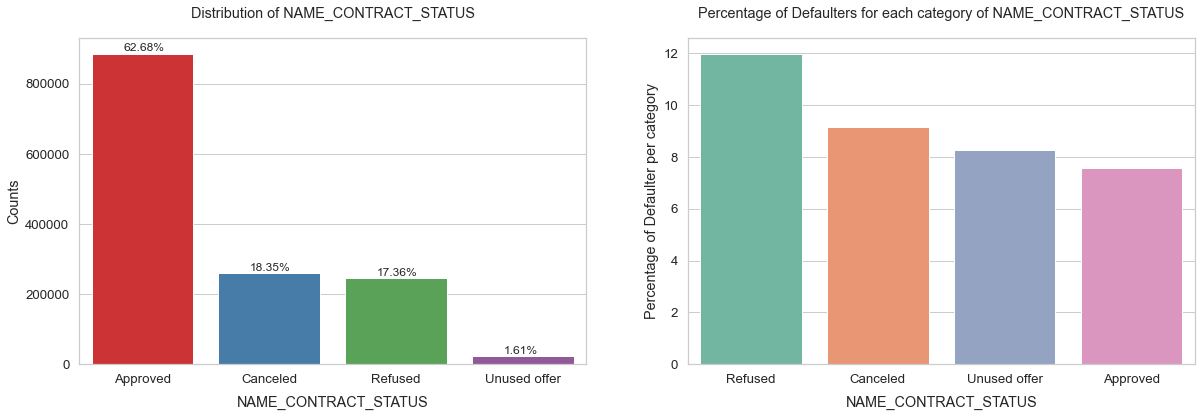

----------------------------------------------------------------------------------------------------


In [48]:
#let us first see the unique categories of 'NAME_CONTRACT_STATUS'
print_unique_categories(prev_merged, 'NAME_CONTRACT_STATUS')

# plotting the Bar Plot for the Column
plot_categorical_variables_bar(prev_merged, 'NAME_CONTRACT_STATUS', horizontal_adjust = 0.25, figsize = (20, 6), fontsize_percent = 'small')
print('-'*100)

Observations and Conclusions:

From the above plots, we see that:

- The most common type of Contract Status is the Approved Status. About 63% of the previous Credits have an Approved Status. The next two common status are Canceled and Refused, which both correspond to about 18% of the loans. This implies that most of the loans get approved and only some fraction of them do not. The least occurring type of contract status is Unused Offer which corresponds to just 1.61% of all the loans.
- Looking at the second subplot for percentage of defaulters, we see that the those loans which previously had Refused Status tend to have defaulted the highest in the current loans. They correspond to about 12% of Defaulters from that category. These are followed by Canceled Status which correspond to close to 9% of Default Rate. This behavious is quite expected logically, as these people must have been refused due to not having adequate profile. The least default rate is observed for Contract Status of Approved.